In [1]:
from shapely.geometry import Point, Polygon
import random
import numpy as np
import pandas as pd
from rich.progress import track
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")

In [2]:
def corr_within_cell_polygon(df, cell_polygon):
    """
    Take a Polygon cell_polygon and a dataframe contain columns 'x' and 'y',
    and return numpy array of x and y within the cell_polygon.
    """
    lst_x = []
    lst_y = []
    for _, row in df.iterrows():
        if Point(row["x"], row["y"]).within(cell_polygon):
            lst_x.append(row["x"])
            lst_y.append(row["y"])
    array_x = np.array(lst_x, dtype=float)
    array_y = np.array(lst_y, dtype=float)
    return array_x, array_y

In [3]:
cell_roi_file = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Praneeth_data/roi.txt"

rna_file = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Praneeth_data/dSTORM7_HEK_EZH2_HALO_SALMON_JF549_ab_CY55-cropped-left-3000f.csv"

condensate_file = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Praneeth_data/dSTORM7_HEK_EZH2_HALO_SALMON_JF549_ab_CY55-cropped-right-3000f.csv"

output_dir = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Praneeth_data/"

In [4]:
nm_per_pxl = 23.4
r_max_nm = 1120
ringwidth_nm = 100
dr_slidingrings_nm = 20  # stepsize between adjacent overlapping rings, nm
bins = np.arange(
    0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
)  # overlapping bins (sliding window)

In [5]:
# Import cell boundary as a polygon
cell_outline_coordinates = pd.read_csv(cell_roi_file, sep="\t", header=None)  # um
coords_roi = [
    tuple(row * 1000 / nm_per_pxl) for _, row in cell_outline_coordinates.iterrows()
]
cell_polygon = Polygon(coords_roi)

# Import condensates (ch1) and RNA/protein (ch2) spots
df_interest = pd.read_csv(
    rna_file,
    skiprows=lambda i: i > 0 and random.random() > 0.1,
)
df_interest["x"] = df_interest["x [nm]"] / nm_per_pxl
df_interest["y"] = df_interest["y [nm]"] / nm_per_pxl
df_ref = pd.read_csv(
    condensate_file,
    skiprows=lambda i: i > 0 and random.random() > 1,
)
df_ref["x"] = df_ref["x [nm]"] / nm_per_pxl
df_ref["y"] = df_ref["y [nm]"] / nm_per_pxl

print(f"Loaded {df_ref.shape[0]} condensate spots")
print(f"Loaded {df_interest.shape[0]} RNA/protein spots")
print(f"Cell area: {cell_polygon.area * (nm_per_pxl**2):.2f} nm²")


# only count particles within cell_polygon
x_ref, y_ref = corr_within_cell_polygon(df_ref, cell_polygon)
x_interest, y_interest = corr_within_cell_polygon(df_interest, cell_polygon)

# Total number particles in cell_polygon
N_ref = x_ref.shape[0]
N_interest = x_interest.shape[0]

# particle density rho, unit: number per nano meter square
cell_polygon_area_nm2 = cell_polygon.area * (nm_per_pxl**2)
rho_ref_per_nm2 = N_ref / cell_polygon_area_nm2
rho_interest_per_nm2 = N_interest / cell_polygon_area_nm2

# setup bins and ring areas
bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
bin_ends = bin_starts + ringwidth_nm
ring_areas_nm2 = np.pi * (bin_ends**2 - bin_starts**2)  # area of rings, unit nm square
ring_areas_pxl2 = ring_areas_nm2 / (nm_per_pxl**2)

Loaded 6403 condensate spots
Loaded 29241 RNA/protein spots
Cell area: 159605252.82 nm²


In [6]:
def quick_PCF(x_ref, y_ref, x_interest, y_interest, N_ref):
    # Calculate corrected histogram of distances
    lst_hist_per_point_cross = []
    for i in track(range(len(x_ref))):
        # Calculate edge correction factor
        rings = [
            Point(x_ref[i], y_ref[i])
            .buffer(end)
            .difference(Point(x_ref[i], y_ref[i]).buffer(start))
            for start, end in zip(bin_starts / nm_per_pxl, bin_ends / nm_per_pxl)
        ]
        intersect_areas = np.array(
            [
                cell_polygon.intersection(Polygon(ring), grid_size=0.1).area
                for ring in rings
            ]
        )
        edge_correction_factors = 1 / (intersect_areas / ring_areas_pxl2)

        # cross correlation
        lst_hist = []
        for j in range(len(x_interest)):
            distance = (
                np.sqrt(
                    (x_ref[i] - x_interest[j]) ** 2 + (y_ref[i] - y_interest[j]) ** 2
                )
                * nm_per_pxl
            )
            lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
        hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
        lst_hist_per_point_cross.append(hist_per_point_corrected)

    # calculate normalization factor that counts for density and ring area
    norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2

    PairCorr_cross = np.sum(lst_hist_per_point_cross, axis=0) / norm_factors_cross

    return PairCorr_cross


# pcf_auto_ref = quick_PCF(x_ref, y_ref, x_ref, y_ref, N_ref)
# pcf_auto_interest = quick_PCF(
#     x_interest, y_interest, x_interest, y_interest, N_interest
# )
pcf_cross = quick_PCF(x_ref, y_ref, x_interest, y_interest, N_ref)

Output()

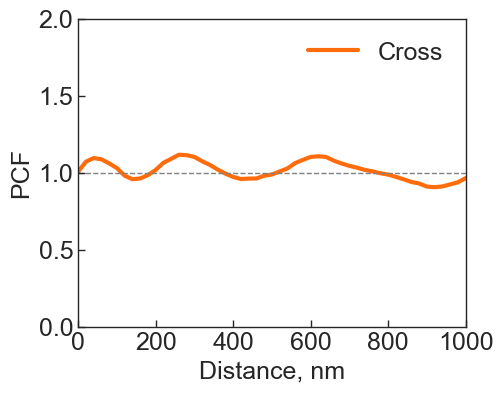

In [ ]:
plt.figure(figsize=(5, 4))
# plt.plot(bins, pcf_auto_ref, lw=3, label="Auto, 1", c="#007BA7")
# plt.plot(bins, pcf_auto_interest, lw=3, label="Auto, 2", c="#DB00DB")
plt.plot(bins, pcf_cross, lw=3, label="Cross", c="#FF6C0C")

plt.axhline(1, ls="--", c="gray", lw=1)

plt.legend(frameon=False, fontsize=18)
plt.xlim(0, 1000)
plt.ylim(0, 2)
plt.xlabel("Distance, nm", fontsize=18)
plt.ylabel("PCF", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)

plt.savefig(
    "crossPCF.png",
    format="png",
    bbox_inches="tight",
    dpi=600,
)